### Date: May 16, 2024 5: 28 PM

# This code estimates irrigation requirement for Soybean  using Penman-Monteith method

Note: Upward Flux equation used ET value from rainfed Corn tab of the spreadsheet. This value was not same as that of calculated ET.
The Flux value got similar results by changing the original ET from rainfed corn to ET = ETo* Kc.
However, we are ignroing the Flux, so it should be fine. 

Kc_Corn function needs to adjust accordingly if we want to include flux or not.

# 1. FAO Penman-Montieth method for estimating Ref. Evapotranspiration

In [1]:
import pandas as pd
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
df_ref = pd.read_excel('../Irrigation_Scheduling_Field70_2023.xlsx', 'Penman', skiprows=2)
df_ref=df_ref.iloc[:, : 26] 
df_ref['Date'] = pd.to_datetime(df_ref['Date'])
df_ref.head()

,Date,Wind Speed,Precipitation,Solar Radiation,Air Temperature,Vapor Pressure,"lambda, l","heat flux, G",Saturation Vapor Pressure,vpd,...,J,dr,declination,sunset hour angle,Ra,Rso,Rnl,Rnet,ETo,ETo.1
0,2023-05-01,5.999999,5.842,55,5.9,7.983117,2.487070,0.744529,0.928655,0.130344,...,121,0.983829,0.261263,1.800938,32.659330,24.633861,-0.571109,4.230149,0.976078,0.038428
1,2023-05-02,0.000000,0.000,119,8.2,7.652452,2.481640,0.744529,1.087469,0.322224,...,122,0.983336,0.266641,1.805998,32.697458,24.662620,1.419116,6.497716,1.250606,0.049236
2,2023-05-03,3.500000,0.000,283,8.9,7.600050,2.479987,0.744529,1.140328,0.380323,...,123,0.982848,0.271940,1.811004,32.733271,24.689632,6.660406,12.167018,2.897172,0.114062
3,2023-05-04,0.000000,0.000,436,18.2,11.571283,2.458030,0.744529,2.090088,0.932959,...,124,0.982366,0.277159,1.815955,32.766827,24.714943,11.402881,17.603327,4.588835,0.180663
4,2023-05-05,0.000000,0.000,439,22.2,11.007096,2.448586,0.744529,2.676334,1.575624,...,125,0.981888,0.282295,1.820848,32.798189,24.738598,12.366348,16.839444,4.678840,0.184206


In [3]:
df_Pen_ref=df_ref.loc[ :, ['Date', 'ETo.1']] 
df_Pen_ref = df_Pen_ref.rename(columns={'ETo.1':'PenmanETo'})    
df_Pen_ref
            

,Date,PenmanETo
0,2023-05-01,0.038428
1,2023-05-02,0.049236
2,2023-05-03,0.114062
3,2023-05-04,0.180663
4,2023-05-05,0.184206
...,...,...
125,2023-09-03,0.175386
126,2023-09-04,0.167250
127,2023-09-05,0.186892
128,2023-09-06,0.145436


In [4]:
df=df_ref.iloc[:, : 6] 
df["month1"]=df["Date"].dt.month

In [5]:
data = {'month1': np.arange(1,13),
        'Temp_avg': [-3.150,-1.345,4.547,11.109,17.016,21.745,22.969,21.738,18.330,11.936,5.572,-0.620]}
 
# Create DataFrame
df2 = pd.DataFrame(data)

# Create a new column and calculate its values using if-else conditions
df2['heat_Flux'] = 0.07 * np.where(df2['month1'] == 1, 
                                    df2['Temp_avg'].shift(-1) - df2['Temp_avg'].iloc[-1],
                                    np.where(df2['month1'] == 12,
                                             df2['Temp_avg'].iloc[0] - df2['Temp_avg'].shift(1),
                                             df2['Temp_avg'].shift(-1) - df2['Temp_avg'].shift(1)))
df=pd.merge(df, df2, left_on='month1', right_on='month1')
df

,Date,Wind Speed,Precipitation,Solar Radiation,Air Temperature,Vapor Pressure,month1,Temp_avg,heat_Flux
0,2023-05-01,5.999999,5.842,55,5.9,7.983117,5,17.016,0.74452
1,2023-05-02,0.000000,0.000,119,8.2,7.652452,5,17.016,0.74452
2,2023-05-03,3.500000,0.000,283,8.9,7.600050,5,17.016,0.74452
3,2023-05-04,0.000000,0.000,436,18.2,11.571283,5,17.016,0.74452
4,2023-05-05,0.000000,0.000,439,22.2,11.007096,5,17.016,0.74452
...,...,...,...,...,...,...,...,...,...
125,2023-09-03,2.600000,0.000,248,25.2,24.425491,9,18.330,-0.68614
126,2023-09-04,2.300000,0.000,225,25.6,24.586407,9,18.330,-0.68614
127,2023-09-05,3.000000,0.000,231,26.0,23.510684,9,18.330,-0.68614
128,2023-09-06,3.899999,1.524,189,23.0,21.858862,9,18.330,-0.68614


In [6]:
df["year"]=df["Date"].dt.year
df['month'] = 1
df['day'] = 1
df['J_Date']=pd.to_datetime(df[["year", "month", "day"]])
df['j']=df['Date'].apply(pd.Timestamp.to_julian_date)-df['J_Date'].apply(pd.Timestamp.to_julian_date)+1


In [7]:
df = df.rename(columns={'Solar Radiation':'radiation','Air Temperature':"Temp",'Wind Speed':'Wind_speed','Vapor Pressure':'V_Pressure'})

#df=df.iloc[0:10,:]


In [8]:
def PET_Penman (Wind_speed, radiation, Temp, V_Pressure, heat_Flux, j):
    lammbda= 2.501-Temp*0.002361 
     
    if Temp > 0:
        Sat_VP = 0.6108 * math.exp(17.27 * Temp / (237.3 + Temp))
    else:
        Sat_VP = V_Pressure * 0.1
        
    vpd= Sat_VP-V_Pressure*0.1
    slope= 4098*0.6108*math.exp(((17.27*Temp)/(Temp+237.3)))/((Temp+237.3)**2)
    
    Pressure= 101.3*((293-0.0065*213.36)/293)**5.26
    gamma  =0.001013*Pressure/(0.622*lammbda)
    sigma=4.903*10**-9
    
    Rbo= sigma*(Temp+273)**4
    Rs= radiation*60*60*24/10e5    
    dr=1+0.033*math.cos(2*math.pi*j/365)
    declination=0.409*math.sin((2*math.pi*j/365)-1.39)
    sunset_angle=math.acos(-1*math.tan(40.469794*math.pi/180)*math.tan(declination))
    Ra=(24*60*0.082/math.pi)*dr*(math.sin(40.469794*math.pi/180)*math.sin(declination)+math.cos(40.469794*math.pi/180)*math.cos(declination)*math.sin(sunset_angle))
    Rso=(213.36*0.00002+0.75)*Ra    
    Rnl=Rbo*(0.34-0.14*math.sqrt(0.1*V_Pressure))*(1.35*(Rs/Rso) - 0.35)      
    Rnet=Rs*(1-0.23)-Rnl
    ETo=(0.408*slope*(Rnet-heat_Flux)+gamma*(900/(Temp+273))*Wind_speed*vpd)/(slope+gamma*(1+0.34*Wind_speed))  
    ETo_in=ETo/25.4
    #return (lammbda,Sat_VP,vpd,slope,Pressure,gamma,sigma,Rbo,Rs,j,dr,declination,sunset_angle,Ra, Rso,Rnl,ETo)
    return ETo, ETo_in


In [9]:
#df['ETo'] = df.apply(lambda row: PET(row['Wind_speed'], row['heat_Flux'], row['radiation'], row['Temp'], row['V_Pressure'],row['j']), axis=1)

# zip allows for multiple columns
%timeit df['ETo_mmDay'], df['ETo_in'] = zip(*df.apply(lambda row: PET_Penman(row['Wind_speed'], row['radiation'], row['Temp'], row['V_Pressure'], row['heat_Flux'],row['j']), axis=1))

#df.ETo_in=df.ETo_in.round(3)
df

3.73 ms ± 600 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Date,Wind_speed,Precipitation,radiation,Temp,V_Pressure,month1,Temp_avg,heat_Flux,year,month,day,J_Date,j,ETo_mmDay,ETo_in
0,2023-05-01,5.999999,5.842,55,5.9,7.983117,5,17.016,0.74452,2023,1,1,2023-01-01,121.0,0.976079,0.038428
1,2023-05-02,0.000000,0.000,119,8.2,7.652452,5,17.016,0.74452,2023,1,1,2023-01-01,122.0,1.250607,0.049237
2,2023-05-03,3.500000,0.000,283,8.9,7.600050,5,17.016,0.74452,2023,1,1,2023-01-01,123.0,2.897173,0.114062
3,2023-05-04,0.000000,0.000,436,18.2,11.571283,5,17.016,0.74452,2023,1,1,2023-01-01,124.0,4.588838,0.180663
4,2023-05-05,0.000000,0.000,439,22.2,11.007096,5,17.016,0.74452,2023,1,1,2023-01-01,125.0,4.678842,0.184206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2023-09-03,2.600000,0.000,248,25.2,24.425491,9,18.330,-0.68614,2023,1,1,2023-01-01,246.0,4.454810,0.175386
126,2023-09-04,2.300000,0.000,225,25.6,24.586407,9,18.330,-0.68614,2023,1,1,2023-01-01,247.0,4.248143,0.167250
127,2023-09-05,3.000000,0.000,231,26.0,23.510684,9,18.330,-0.68614,2023,1,1,2023-01-01,248.0,4.747040,0.186891
128,2023-09-06,3.899999,1.524,189,23.0,21.858862,9,18.330,-0.68614,2023,1,1,2023-01-01,249.0,3.694065,0.145436


## The Ref ET estimated using Penman-Monteith:

In [10]:
#df.loc[(df.Date >= '2023-08-30') & (df.Date <= '2023-09-10')]
#df=df[['Date','Wind_speed','Precipitation','radiation','Temp','V_Pressure','ETo_mmDay','ETo_in']]
df=df[['Date','Precipitation','ETo_in']]
df['Precipitation']=df['Precipitation']/25.4
df

C:\Users\tbijoych\AppData\Local\Temp\ipykernel_12816\801641425.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Precipitation']=df['Precipitation']/25.4


,Date,Precipitation,ETo_in
0,2023-05-01,0.23,0.038428
1,2023-05-02,0.00,0.049237
2,2023-05-03,0.00,0.114062
3,2023-05-04,0.00,0.180663
4,2023-05-05,0.00,0.184206
...,...,...,...
125,2023-09-03,0.00,0.175386
126,2023-09-04,0.00,0.167250
127,2023-09-05,0.00,0.186891
128,2023-09-06,0.06,0.145436


## Assessment of Penman ETo:

In [11]:
df_merge= df.merge (df_Pen_ref, how='left', on='Date')


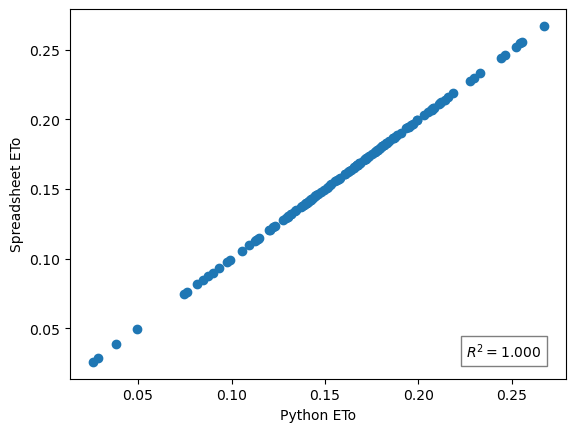

In [12]:
from sklearn.metrics import r2_score

fig, ax = plt.subplots()
plt.xlabel('Python ETo')
plt.ylabel('Spreadsheet ETo')
ax.scatter(df_merge['ETo_in'], df_merge['PenmanETo'])

r_squared = r2_score(df_merge['ETo_in'], df_merge['PenmanETo'])

ax.annotate(r"$R^2 = {:.3f}$".format(r_squared), xy=(0.95, 0.05), xycoords='axes fraction',
            ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

# 2. Crop Coefficent: Soybean 

In [13]:
df_Soybean = pd.read_excel('../Irrigation_Scheduling_Field70_2023.xlsx', 'Soy Irr', skiprows=6)
df_Soybean=df_Soybean.iloc[1:168, : 26] 
df_Soybean['Date']=pd.to_datetime(df_Soybean['Date']).dt.date
df_Soybean['Date'] = pd.to_datetime(df_Soybean['Date'])
#df_Soybean.columns
df_Soybean

,Date,Week\nPast\nEmer-gence\n(WPE),Penman Eto,Kc,Unstressed Crop ET,Irrigation Length,Crop ET\n(ET),Effective Rain\n®,Shallow grondwater cont. (UF),Effective Irrigation\n(I),...,Total\nET,Total\nRain,Total\nIrrigation,Total\nWater Losses,Notes,Depth to wtable (m),0-6 in,6 - 12 in,12 - 18 in,18 - 24 in
1,2023-05-01,0,0.038428,0.2,0.007686,0,0.007686,0.23,0.00451,NaN,...,0.007686,0.23,0,0,NaN,1.2,0.195333,0.293667,0.366333,0.397333
2,2023-05-02,0,0.049236,0.2,0.009847,0,0.009847,0,0.005779,NaN,...,0.017533,0.23,0,0,NaN,1.2,0.195333,0.293667,0.366333,0.397333
3,2023-05-03,0,0.114062,0.2,0.022812,0,0.022812,0,0.013387,NaN,...,0.040345,0.23,0,0,NaN,1.2,0.195333,0.293667,0.366333,0.397333
4,2023-05-04,0,0.180663,0.2,0.036133,0,0.036133,0,0.021204,NaN,...,0.076478,0.23,0,0,NaN,1.2,0.195333,0.293667,0.366333,0.397333
5,2023-05-05,0,0.184206,0.2,0.036841,0,0.036841,0,0.02162,NaN,...,0.113319,0.23,0,0,NaN,1.2,0.195333,0.293667,0.366333,0.397333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2023-10-10,0,0.025774,0.2,0.005155,0.112961,0.005155,0,0,NaN,...,11.842476,14.190394,1.7395,7.969184,NaN,NaN,NaN,NaN,NaN,NaN
164,2023-10-11,0,0.025774,0.2,0.005155,0.112961,0.005155,0,0,NaN,...,11.84763,14.190394,1.7395,7.969184,NaN,NaN,NaN,NaN,NaN,NaN
165,2023-10-12,0,0.025774,0.2,0.005155,0.112961,0.005155,0,0,NaN,...,11.852785,14.190394,1.7395,7.969184,NaN,NaN,NaN,NaN,NaN,NaN
166,2023-10-13,0,0.025774,0.2,0.005155,0.112961,0.005155,0,0,NaN,...,11.85794,14.190394,1.7395,7.969184,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:

df_Kc=df_Soybean[['Date','Soil-Water Deficit Percent (Adjusted)\n(SWDPadj)','Effective Irrigation\n(I)','Depth to wtable (m)', '0-6 in', '6 - 12 in', '12 - 18 in',
       '18 - 24 in']]

#df_Kc = df_Kc.rename(columns={'Week\nPast\nEmer-gence\n(WPE)':'WPE','Soil-Water Deficit Percent\n(SWDP)':'SWDP'})
df_Kc = df_Kc.rename(columns={'Soil-Water Deficit Percent (Adjusted)\n(SWDPadj)':'SWDPadj','Effective Irrigation\n(I)':'eff_irr',
                             'Depth to wtable (m)':'WTable', '0-6 in':"WT0_6in",'6 - 12 in':"WT6_12in",'12 - 18 in':"WT12_18in",'18 - 24 in':"WT18_24in"})
df_Kc['SWDPadj'] = df_Kc['SWDPadj'].fillna('a')
df_Kc['WTable']=df_Kc['WTable'].fillna(1.3)
df_Kc=df_Kc.fillna(0)
df_Kc

,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in
1,2023-05-01,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333
2,2023-05-02,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333
3,2023-05-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333
4,2023-05-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333
5,2023-05-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333
...,...,...,...,...,...,...,...,...
163,2023-10-10,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000
164,2023-10-11,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000
165,2023-10-12,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000
166,2023-10-13,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000


In [15]:
df_Kc['Date']=pd.to_datetime(df_Kc['Date']).dt.date
df_Kc['Date'] = pd.to_datetime(df_Kc['Date'])
df_Kc.head()

,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in
1,2023-05-01,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333
2,2023-05-02,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333
3,2023-05-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333
4,2023-05-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333
5,2023-05-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333


In [16]:
Emergence = pd.to_datetime(["5/16/2023"]) # actual date is 5/13/2023 & date are in mm-dd-yy 23:59 format. This enable to get actual RZ value
Harvest = pd.to_datetime(["10/1/2023"])


In [17]:
def calculate_WPE(date):
    if date < Emergence:
        return 0
    elif date > Harvest:
        return 0
    else:
        return ((((date-Emergence).days)/7).astype(int)+1)[0]

df_Kc['WPE']=df_Kc['Date'].apply(calculate_WPE)


## 2.1 Average Weekly crop coefficient for Soybean in Indiana

In [18]:
Soybean_Kc_Indiana= {'Tmax_F': [1] * 22 ,
    'WPE': np.arange(1,23),
        'Kc_avg': [0.138, 0.181, 0.2367, 0.29667, 0.36333, 0.4533, 0.5589, 0.6511, 0.74, 0.8233, 0.9044, 0.9767, 0.9978, 0.9422, 0.87, 0.7867, 0.7211, 0.66, 0.1, 0.1, 0.1, 0.1]}

Soybean_Kc_Indiana = pd.DataFrame(Soybean_Kc_Indiana)
#Corn_Kc_Indiana["new"]= Corn_Kc_Indiana['Kc_avg'].shift(1)# delete it
Soybean_Kc_Indiana.tail()

,Tmax_F,WPE,Kc_avg
17,1,18,0.66
18,1,19,0.10
19,1,20,0.10
20,1,21,0.10
21,1,22,0.10


In [19]:
df_Kc=df_Kc.merge(Soybean_Kc_Indiana, on='WPE', how='left')

df_Kc = df_Kc.drop('Tmax_F', axis=1)
df_Kc['Kc_avg'] = df_Kc['Kc_avg'].fillna(0)
df_Kc

,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in,WPE,Kc_avg
0,2023-05-01,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0
1,2023-05-02,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0
2,2023-05-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0
3,2023-05-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0
4,2023-05-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0
...,...,...,...,...,...,...,...,...,...,...
162,2023-10-10,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0
163,2023-10-11,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0
164,2023-10-12,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0
165,2023-10-13,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0


# 3. Merge Penman Monteith ETo and Soybean weekly Kc

In [20]:
dat=df_Kc.merge(df, on='Date', how='left')
dat=dat.rename(columns={'Precipitation':'Eff_Rain'})
#dat=dat.iloc[0:130] # to reomve nan rows   
dat['Eff_Rain'] = dat['Eff_Rain'].fillna(0)

In [21]:
if dat.index.max() > 129:   
    dat.loc[dat.index > 129, 'ETo_in'] = dat.iloc[129]['ETo_in']
dat   

,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in,WPE,Kc_avg,Eff_Rain,ETo_in
0,2023-05-01,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.23,0.038428
1,2023-05-02,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.049237
2,2023-05-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.114062
3,2023-05-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.180663
4,2023-05-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.184206
...,...,...,...,...,...,...,...,...,...,...,...,...
162,2023-10-10,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,0.025774
163,2023-10-11,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,0.025774
164,2023-10-12,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,0.025774
165,2023-10-13,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,0.025774


In [22]:
WA_rate = 0.045632799 # water applicationr ate (in/hr)- ned to calculate
RZinitial=4
RZMD=24  # Root Zone Maximum Depth (in)
W_RZMD=7 # week of RZMD
Emergence = pd.to_datetime(["5/15/2023"]) # actual date is 5/16/2023 & date are in mm-dd-yy 23:59 format. This enable to get actual RZ value

In [23]:
# check spreadsheet how RZ max is 24. Therefore, i use a if condition for rz>24, rz=24
def RZ_all (Date, WPE):
    
    if Date <= Emergence:
        RZ=RZinitial
    elif Date > Harvest:
        RZ=RZinitial
    elif Date > Emergence and WPE < W_RZMD:
        RZ= RZ_previous_step + (RZMD - RZinitial) / ((W_RZMD- 1) * 7)
    else:
        RZ=RZMD
    
    if RZ>24:
        RZ=24
    else:
        RZ=RZ
        
    return RZ   

for index, row in dat.iterrows():
    RZ = RZ_all(row['Date'], row['WPE'])
    # if index==1:
    #     RZ_previous_step=4
    # else:
    #     RZ_previous_step = RZ    
    RZ_previous_step = RZ   
    
    dat.at[index, 'RZ'] = RZ
    
#df_Kc.iloc[51:70]



In [24]:
Soil_table = pd.DataFrame({
    'Layer': np.arange(0,8),
    'From': [0,0,6,12,18,24,48,48],
    'To': [0,6,12,18,24,48,48,48],
    'Thickness': [0,6,6,6,6,0,0,0],
    'AWHC': [0,0.23,0.23,0.21,0.2,0,0,0]})


Soil_table['AWHCj']=Soil_table['Thickness']*Soil_table['AWHC']
Soil_table['AWHCj_cum']=Soil_table['AWHCj'].cumsum()
Soil_table1=Soil_table[['To','AWHCj_cum']]

In [25]:
def AWHCrz_func(rz):    
    if rz in Soil_table1['To'].values:
        i = Soil_table1.index[Soil_table1['To'] == rz][0]
        dfx = Soil_table1.iloc[i:i+2]
    else:
        Soil_table1["To"] > rz
        v = Soil_table1["To"] > rz 
        i = v[v].index[0]   
        dfx = Soil_table1.iloc[i-1:i+1]
      
    
    AWHCrz= ((rz-dfx.iloc[0][0])/(dfx.iloc[1][0]-dfx.iloc[0][0]))* (dfx.iloc[1][1]-dfx.iloc[0][1])+dfx.iloc[0][1]        
            
    return AWHCrz

dat['AWHCrz'] = dat.apply(lambda x: AWHCrz_func(x['RZ']), axis=1)

dat

,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in,WPE,Kc_avg,Eff_Rain,ETo_in,RZ,AWHCrz
0,2023-05-01,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.23,0.038428,4.0,0.92
1,2023-05-02,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.049237,4.0,0.92
2,2023-05-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.114062,4.0,0.92
3,2023-05-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.180663,4.0,0.92
4,2023-05-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.184206,4.0,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2023-10-10,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,0.025774,4.0,0.92
163,2023-10-11,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,0.025774,4.0,0.92
164,2023-10-12,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,0.025774,4.0,0.92
165,2023-10-13,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,0.025774,4.0,0.92


In [26]:
SWDPcritical=0.7 #SWD (%) level beyond which ET is reduced due to drought stress
SWDP_1=0
SWD_1=0
#WL=0
thetaS= 26.04
thetaR= 4.28
Ds = 0.3
Dd = 1.3
k=1
def Kc_Corn (Date, WPE, Kc_avg, ETo_in, AWHCrz, Eff_Rain, eff_irr, SWDPadj, WTable, WT0_6in, WT6_12in, WT12_18in, WT18_24in):
          
    # if WPE > 0:
    #     if SWDP_1 <= SWDPcritical:
    #         Kc=1
    #     else:
    #         Kc=Kc_avg #Kc=((1-SWDP_1)/(1-SWDPcritical))*Kc_avg --? this is the equation but used same table of kc avergae
    # else:
    #     Kc=0.2
     
    if WPE == 0:
        Kc=0.2
    else:
        Kc=Kc_avg 
        
    unstressed_ET=Kc*ETo_in   
    ET=Kc*ETo_in        
    
  
      
    # UFlux#
    SM_60=6*(WT0_6in+WT6_12in+WT12_18in+WT18_24in)
    
    if SM_60>0:
        rel_SM=(SM_60-thetaR)/(thetaS-thetaR)
    else:
        rel_SM=0    
    rel_WT= (Ds-WTable)/(Ds-Dd) 
    
    if rel_SM > 0:        
        multiplier= (1-rel_WT)**(k*math.sin(rel_SM*(math.pi/2)))
    else:       
        multiplier= (1-rel_WT)**(k*math.sin(1*(math.pi/2)))
        
    if WTable<Ds:
        U_Flux= ET
    elif WTable >Dd:
        U_Flux= 0
    else:
        U_Flux= ET*multiplier
    

    ##############
    if index == 0:
        WL=0
    elif (SWD_1+ET-Eff_Rain-eff_irr) < 0:
        WL= -SWD_1-ET+Eff_Rain+eff_irr # with flux WL= -SWD_1-ET+Eff_Rain+eff_irr+U_Flux 
    else:
        WL=0  
        
    if index==0:
        SWD=0
    elif SWDPadj != 'a':
        SWD = SWDPadj * AWHCrz
    else:        
        SWD = SWD_1+ET+WL-Eff_Rain-eff_irr # with flux,  SWD = SWD_1+ET+WL-Eff_Rain-eff_irr-U_Flux
    
    
    if index==0:
        SWDP=0
    else:
        SWDP=SWD/AWHCrz
    
    
    if SWDP_1 > 0.3:
        Irr_len= ET/WA_rate
    else:
        Irr_len=0       
  
        
        
    OUTPUT=(WL, ET,   Kc, Irr_len, U_Flux, SWD,  SWDP) 
    return OUTPUT




In [27]:
for index, i in dat.iterrows():
   
    OUT = Kc_Corn( i['Date'], i['WPE'], i['Kc_avg'], i['ETo_in'], i['AWHCrz'],i['Eff_Rain'], i['eff_irr'],i['SWDPadj'], i['WTable'], i['WT0_6in'], i['WT6_12in'], i['WT12_18in'], i['WT18_24in'])    
            
    SWD_1 = OUT[5]  
    #SWDP_1 = OUT[5]   
    
    OUT = pd.DataFrame(OUT)
    OUT=OUT.T
    OUT.columns = ["WL", "ET",'Kc','Irr_len','U_Flux','SWD','SWDP']  
   
   
    dat.at[index, 'WL'] = OUT['WL'].iloc[0]      
    dat.at[index, 'ET'] = OUT['ET'].iloc[0]
    dat.at[index, 'Kc'] = OUT['Kc'].iloc[0]
    dat.at[index, 'Irr_len'] = OUT['Irr_len'].iloc[0]
    dat.at[index, 'U_Flux'] = OUT['U_Flux'].iloc[0]
    
    dat.at[index, 'SWD'] = OUT['SWD'].iloc[0]
    dat.at[index, 'SWDP'] = OUT['SWDP'].iloc[0]

dat



,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in,WPE,Kc_avg,...,ETo_in,RZ,AWHCrz,WL,ET,Kc,Irr_len,U_Flux,SWD,SWDP
0,2023-05-01,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,...,0.038428,4.0,0.92,0.0,0.007686,0.2,0.0,0.004510,0.000000,0.000000
1,2023-05-02,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,...,0.049237,4.0,0.92,0.0,0.009847,0.2,0.0,0.005779,0.009847,0.010704
2,2023-05-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,...,0.114062,4.0,0.92,0.0,0.022812,0.2,0.0,0.013387,0.032660,0.035500
3,2023-05-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,...,0.180663,4.0,0.92,0.0,0.036133,0.2,0.0,0.021204,0.068792,0.074774
4,2023-05-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,...,0.184206,4.0,0.92,0.0,0.036841,0.2,0.0,0.021620,0.105634,0.114819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2023-10-10,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,...,0.025774,4.0,0.92,0.0,0.005155,0.2,0.0,0.000000,1.551340,1.686239
163,2023-10-11,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,...,0.025774,4.0,0.92,0.0,0.005155,0.2,0.0,0.000000,1.556495,1.691842
164,2023-10-12,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,...,0.025774,4.0,0.92,0.0,0.005155,0.2,0.0,0.000000,1.561649,1.697445
165,2023-10-13,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,...,0.025774,4.0,0.92,0.0,0.005155,0.2,0.0,0.000000,1.566804,1.703048


In [28]:
dat=dat[['Date', 'WPE','ETo_in','Kc','Irr_len','ET','Eff_Rain', 'U_Flux','eff_irr','SWD', 'SWDP','SWDPadj', 'WL', 'RZ', 'AWHCrz']]
dat.tail()

,Date,WPE,ETo_in,Kc,Irr_len,ET,Eff_Rain,U_Flux,eff_irr,SWD,SWDP,SWDPadj,WL,RZ,AWHCrz
162,2023-10-10,0,0.025774,0.2,0.0,0.005155,0.0,0.0,0.0,1.551340,1.686239,a,0.0,4.0,0.92
163,2023-10-11,0,0.025774,0.2,0.0,0.005155,0.0,0.0,0.0,1.556495,1.691842,a,0.0,4.0,0.92
164,2023-10-12,0,0.025774,0.2,0.0,0.005155,0.0,0.0,0.0,1.561649,1.697445,a,0.0,4.0,0.92
165,2023-10-13,0,0.025774,0.2,0.0,0.005155,0.0,0.0,0.0,1.566804,1.703048,a,0.0,4.0,0.92
166,2023-10-14,0,0.025774,0.2,0.0,0.005155,0.0,0.0,0.0,1.571959,1.708651,a,0.0,4.0,0.92


In [29]:
dat.loc[:, 'Total_ET'] = dat['ET'].cumsum()
dat.loc[:, 'Total_Rain'] = dat['Eff_Rain'].cumsum()
dat.loc[:, 'Total_Irr'] = dat['eff_irr'].cumsum()
dat.loc[:, 'Total_WL'] = dat['WL'].cumsum()

dat.tail()

#dat_check=dat.merge(df_Soy_ref, how='left', on='Date')
#dat_check.to_csv('../out_soybean.csv', index=True) 

C:\Users\tbijoych\AppData\Local\Temp\ipykernel_12816\160052916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[:, 'Total_ET'] = dat['ET'].cumsum()
C:\Users\tbijoych\AppData\Local\Temp\ipykernel_12816\160052916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[:, 'Total_Rain'] = dat['Eff_Rain'].cumsum()
C:\Users\tbijoych\AppData\Local\Temp\ipykernel_12816\160052916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,Date,WPE,ETo_in,Kc,Irr_len,ET,Eff_Rain,U_Flux,eff_irr,SWD,SWDP,SWDPadj,WL,RZ,AWHCrz,Total_ET,Total_Rain,Total_Irr,Total_WL
162,2023-10-10,0,0.025774,0.2,0.0,0.005155,0.0,0.0,0.0,1.551340,1.686239,a,0.0,4.0,0.92,11.838703,14.190394,1.7395,6.233795
163,2023-10-11,0,0.025774,0.2,0.0,0.005155,0.0,0.0,0.0,1.556495,1.691842,a,0.0,4.0,0.92,11.843858,14.190394,1.7395,6.233795
164,2023-10-12,0,0.025774,0.2,0.0,0.005155,0.0,0.0,0.0,1.561649,1.697445,a,0.0,4.0,0.92,11.849013,14.190394,1.7395,6.233795
165,2023-10-13,0,0.025774,0.2,0.0,0.005155,0.0,0.0,0.0,1.566804,1.703048,a,0.0,4.0,0.92,11.854168,14.190394,1.7395,6.233795
166,2023-10-14,0,0.025774,0.2,0.0,0.005155,0.0,0.0,0.0,1.571959,1.708651,a,0.0,4.0,0.92,11.859322,14.190394,1.7395,6.233795


## Assessment of Total ET, Irrigation and Wloss:

In [30]:
df_Soy_ref=df_Soybean[['Date', 'Total\nET', 'Total\nRain', 'Total\nIrrigation', 'Total\nWater Losses']]
df_Soy_ref = df_Soy_ref.rename(columns={'Total\nET':'Total_ET_ref', 'Total\nRain': 'Total_rain_ref', 'Total\nIrrigation':'Total_irri_ref', 'Total\nWater Losses':'Total_WL_ref'})
df_Soy_ref

,Date,Total_ET_ref,Total_rain_ref,Total_irri_ref,Total_WL_ref
1,2023-05-01,0.007686,0.23,0,0
2,2023-05-02,0.017533,0.23,0,0
3,2023-05-03,0.040345,0.23,0,0
4,2023-05-04,0.076478,0.23,0,0
5,2023-05-05,0.113319,0.23,0,0
...,...,...,...,...,...
163,2023-10-10,11.842476,14.190394,1.7395,7.969184
164,2023-10-11,11.84763,14.190394,1.7395,7.969184
165,2023-10-12,11.852785,14.190394,1.7395,7.969184
166,2023-10-13,11.85794,14.190394,1.7395,7.969184


In [31]:
dat1=dat.loc[ :, ['Date', 'Total_ET', 'Total_Rain', 'Total_Irr','Total_WL']]
dat_soy_merge= dat1.merge(df_Soy_ref, how='left', on='Date')
dat_soy_merge	

,Date,Total_ET,Total_Rain,Total_Irr,Total_WL,Total_ET_ref,Total_rain_ref,Total_irri_ref,Total_WL_ref
0,2023-05-01,0.007686,0.230000,0.0000,0.000000,0.007686,0.23,0,0
1,2023-05-02,0.017533,0.230000,0.0000,0.000000,0.017533,0.23,0,0
2,2023-05-03,0.040345,0.230000,0.0000,0.000000,0.040345,0.23,0,0
3,2023-05-04,0.076478,0.230000,0.0000,0.000000,0.076478,0.23,0,0
4,2023-05-05,0.113319,0.230000,0.0000,0.000000,0.113319,0.23,0,0
...,...,...,...,...,...,...,...,...,...
162,2023-10-10,11.838703,14.190394,1.7395,6.233795,11.842476,14.190394,1.7395,7.969184
163,2023-10-11,11.843858,14.190394,1.7395,6.233795,11.84763,14.190394,1.7395,7.969184
164,2023-10-12,11.849013,14.190394,1.7395,6.233795,11.852785,14.190394,1.7395,7.969184
165,2023-10-13,11.854168,14.190394,1.7395,6.233795,11.85794,14.190394,1.7395,7.969184


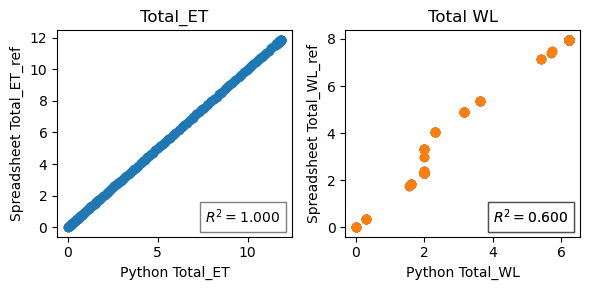

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# First plot for Total_ET vs Total_ET_ref
ax1.set_xlabel('Python Total_ET')
ax1.set_ylabel('Spreadsheet Total_ET_ref')
ax1.scatter(dat_soy_merge['Total_ET'], dat_soy_merge['Total_ET_ref'])
r_squared1 = r2_score(dat_soy_merge['Total_ET'], dat_soy_merge['Total_ET_ref'])
ax1.annotate(r"$R^2 = {:.3f}$".format(r_squared1), xy=(0.95, 0.05), xycoords='axes fraction',
             ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
ax1.set_title('Total_ET')

# Second plot for Total_Rain vs Total_Rain_ref
ax2.set_xlabel('Python Total_WL')
ax2.set_ylabel('Spreadsheet Total_WL_ref')
ax2.scatter(dat_soy_merge['Total_WL'], dat_soy_merge['Total_WL_ref'])
r_squared2 = r2_score(dat_soy_merge['Total_WL'], dat_soy_merge['Total_WL_ref'])
ax2.annotate(r"$R^2 = {:.3f}$".format(r_squared2), xy=(0.95, 0.05), xycoords='axes fraction',
             ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
ax2.set_title('Total WL')

# Third plot for Total_Rain vs Total_Rain_ref
ax2.set_xlabel('Python Total_WL')
ax2.set_ylabel('Spreadsheet Total_WL_ref')
ax2.scatter(dat_soy_merge['Total_WL'], dat_soy_merge['Total_WL_ref'])
r_squared2 = r2_score(dat_soy_merge['Total_WL'], dat_soy_merge['Total_WL_ref'])
ax2.annotate(r"$R^2 = {:.3f}$".format(r_squared2), xy=(0.95, 0.05), xycoords='axes fraction',
             ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
ax2.set_title('Total WL')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Plots:  Irrigation requirements and related terms

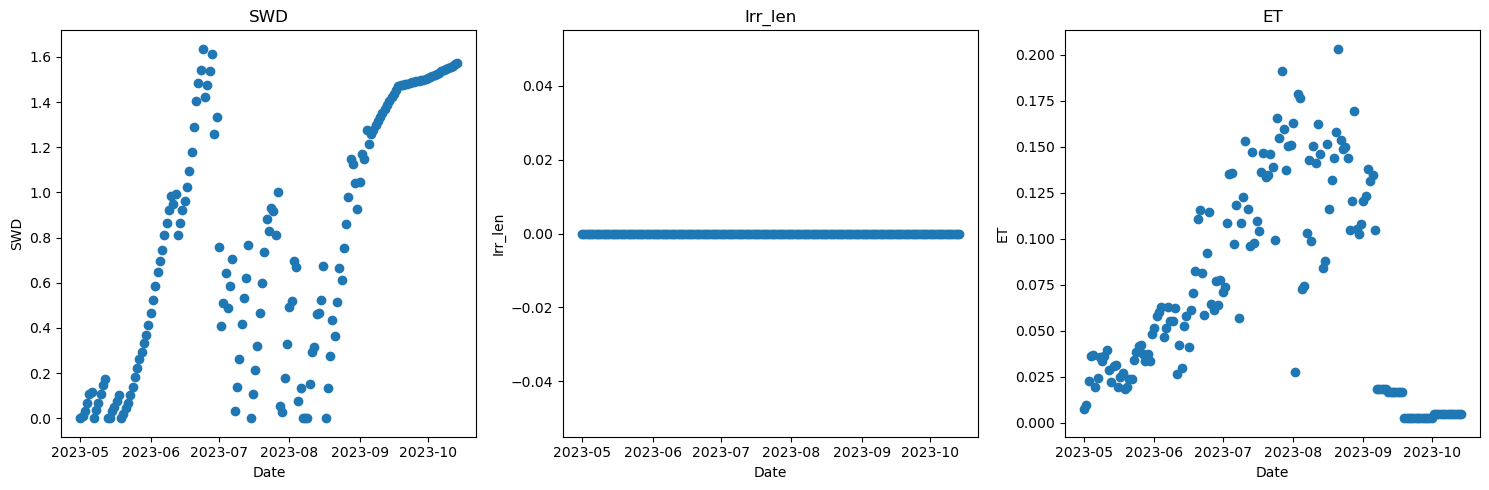

In [33]:
fig, (ay1, ay2, ay3) = plt.subplots(1, 3, figsize=(15, 5))

# First plot for Total_ET vs Total_ET_ref
ay1.set_xlabel('Date')
ay1.set_ylabel('SWD')
ay1.scatter(dat['Date'], dat['SWD'])
ay1.set_title('SWD')

# Second plot for Total_Rain vs Total_Rain_ref
ay2.set_xlabel('Date')
ay2.set_ylabel('Irr_len')
ay2.scatter(dat['Date'], dat['Irr_len'])
ay2.set_title('Irr_len')

# Third plot for Total_Rain vs Total_Rain_ref
ay3.set_xlabel('Date')
ay3.set_ylabel('ET')
ay3.scatter(dat['Date'], dat['ET'])
ay3.set_title('ET')
# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Plots: Daily Irrigation requirements : Following two chunks work well

In [34]:
# today = pd.Timestamp.today().strftime('%Y-%m-%d')
# Irri_today= dat.loc[dat['Date'] == today]
# Irri_todayT=Irri_today.T
# Irri_todayT['try']=1.2 # to check the plot
# Irri_todayT.columns=['Today_value']
# Irri_todayT['Today_value'] = pd.to_numeric(Irri_todayT['Today_value'], errors='coerce')
# Irri_todayT=Irri_todayT.dropna(subset=['Today_value'])
# formatted_today = pd.Timestamp.today().strftime("%B %d, %Y")

In [35]:
# fig, ax = plt.subplots(1, 1, figsize=(13, 5))

# bars = Irri_todayT.plot.bar(ax=ax, y='Today_value', rot=0)
# for bar in bars.patches:
#     ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, round(bar.get_height(), 2), 
#             ha='center', va='bottom')
# plt.xticks(rotation=45)

# ax.set_title('Irrigation Requirement for '+ formatted_today)
# ax.get_legend().remove()
# plt.show()

## Need to check:
1. check effective irrigation  & hence affected WL, total irrigation, total water loss
2. KC value takes from weekly average kc value